In [1]:
import json
import os

depth = 3
directory_path = f'./airflow/cleaned_data_{depth}'
data = []

for file in os.scandir(directory_path):
    try:
        with open(file.path, 'r') as f: 
            data.extend(json.load(f))

    except Exception as e:
        print(f"Error reading {file.name}: {e}")

In [2]:
og_len = len(data)
og_len

387528

In [3]:
import pandas as pd

data = pd.DataFrame(data)
data = data.sort_values(by='layer', ascending=True)
data


,title,sub_title,text,category,layer
387527,Young subgroup,None,"Inmathematics, theYoung subgroupsof thesymmetr...",Combinatorics,1
154432,Projective plane,Finite projective planes,It can be shown that a projective plane has th...,Algebraic geometry,1
154431,Projective plane,Correlations,Adualityis a map from a projective planeto its...,Algebraic geometry,1
154430,Projective plane,Plane duality,A projective plane is defined axiomatically as...,Algebraic geometry,1
154429,Projective plane,Homography,Ahomography(orprojective transformation) of PG...,Algebraic geometry,1
...,...,...,...,...,...
197179,Futures techniques,Introduction,Futures techniquesused in the multi-disciplina...,Analysis,3
197180,Futures techniques,Delphi method,The Delphi method is a popular technique used ...,Analysis,3
197181,Futures techniques,Causal layered analysis (CLA),"This method, developed bySohail Inayatullah, i...",Analysis,3
197151,Futures studies,Branching trends,"Very often, trends relate to one another the s...",Analysis,3


In [4]:
data = data.drop_duplicates(subset=['text', 'sub_title'])
print(f'{len(data)/og_len:.2%} of df remained')

64.14% of df remained


In [5]:
data['length'] = data['text'].apply(lambda x: len(x.split()))
data.describe(include='all')

/tmp/ipykernel_5303/1579233866.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['length'] = data['text'].apply(lambda x: len(x.split()))


,title,sub_title,text,category,layer,length
count,248560,236222,248560,248560,248560,248560.000000
unique,45624,122944,247970,30,3,NaN
top,List of fellows of the American Statistical As...,Introduction,*,Applied mathematics,3,NaN
freq,108,33243,87,64166,134604,NaN
mean,NaN,NaN,NaN,NaN,NaN,162.247083
std,NaN,NaN,NaN,NaN,NaN,215.977352
min,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,59.000000
50%,NaN,NaN,NaN,NaN,NaN,115.000000
75%,NaN,NaN,NaN,NaN,NaN,204.000000


In [8]:
data = data[data['length'] <= 300]
data = data[data['length'] >= 10]
print(f'{len(data)/og_len:.2%} of df remained')
data.describe(include='all')

54.74% of df remained


,title,sub_title,text,category,layer,length
count,212147,201051,212147,212147,212147,212147.000000
unique,43550,104767,212118,30,3,NaN
top,List of non-coherent units of measurement,Introduction,Image:Special fields: This type does not exist...,Applied mathematics,3,NaN
freq,95,30673,5,54456,114101,NaN
mean,NaN,NaN,NaN,NaN,NaN,116.103414
std,NaN,NaN,NaN,NaN,NaN,72.752545
min,NaN,NaN,NaN,NaN,NaN,10.000000
25%,NaN,NaN,NaN,NaN,NaN,56.000000
50%,NaN,NaN,NaN,NaN,NaN,102.000000
75%,NaN,NaN,NaN,NaN,NaN,166.000000


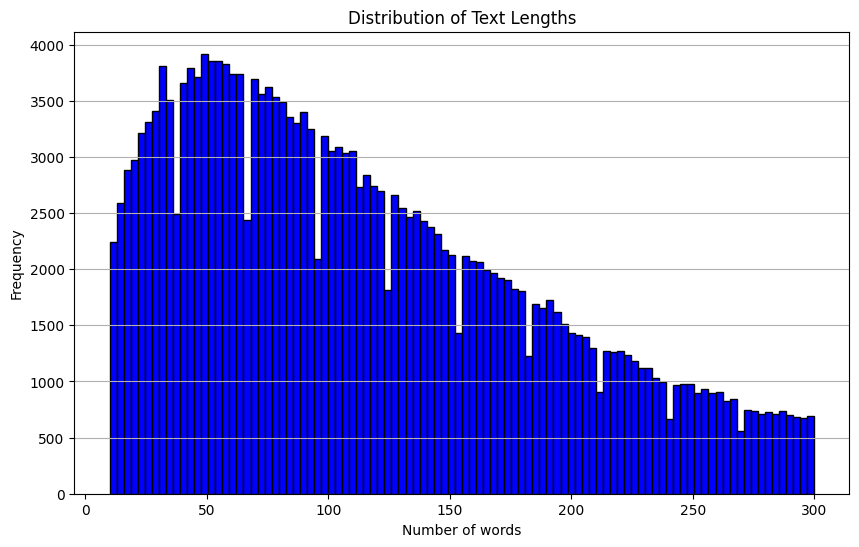

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(data['length'], bins=100, color='blue', edgecolor='black')
plt.title('Distribution of Text Lengths')
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

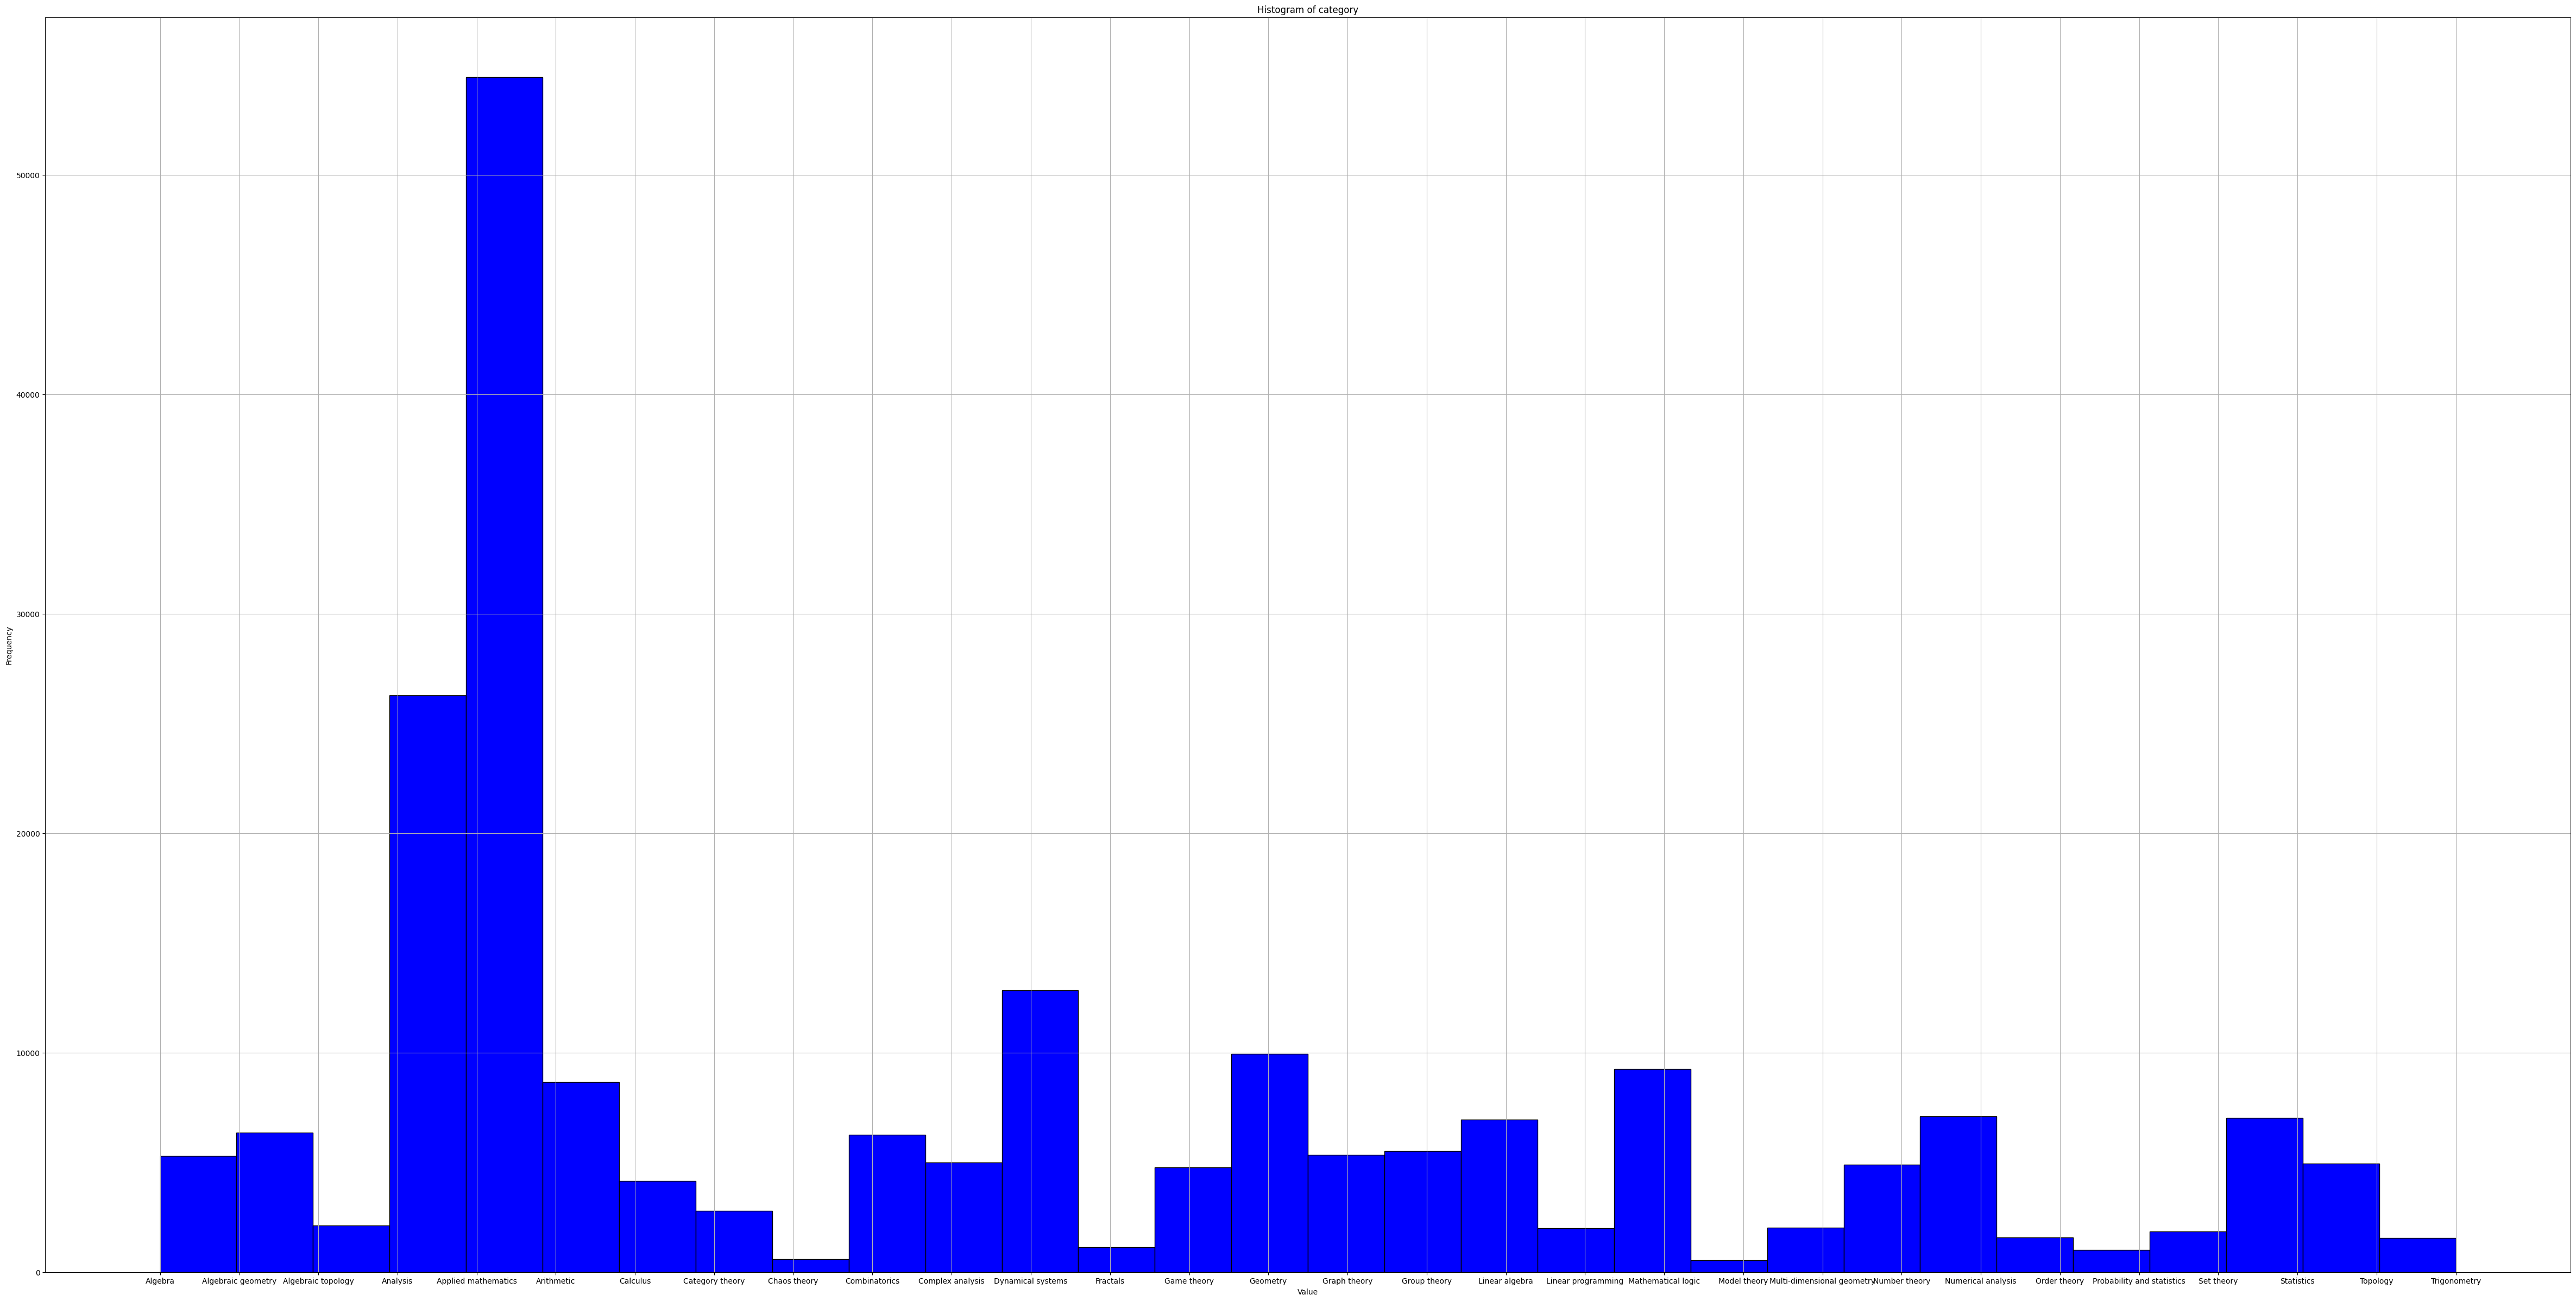

In [10]:
plt.figure(figsize=(60,30))

data.sort_values(by='category')['category'].hist(bins=len(data['category'].unique()), color='blue', edgecolor='black')
plt.title('Histogram of category')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

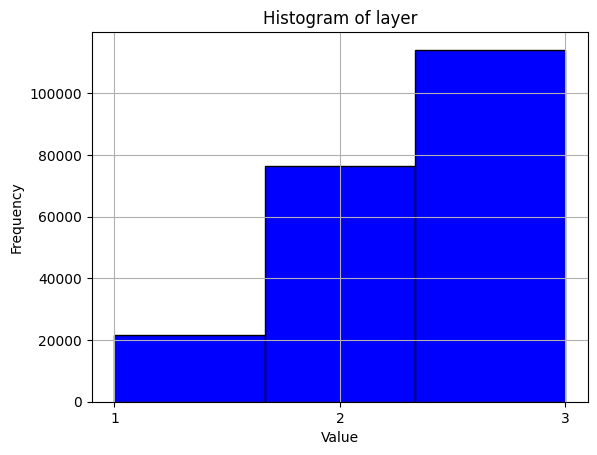

In [11]:
data.sort_values(by='layer')['layer'].hist(bins=len(data['layer'].unique()), color='blue', edgecolor='black')
plt.title('Histogram of layer')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [18]:
rag_df = data[data['layer'] == f'{depth}'] 
fine_tune_df = data[data['layer'] != f'{depth}']

rag_df = pd.concat([rag_df, fine_tune_df[fine_tune_df['length'] > 150]], axis=0)
fine_tune_df = fine_tune_df[fine_tune_df['length'] <= 150]

In [19]:
fine_tune_df.describe(include='all')

,title,sub_title,text,category,layer,length
count,68838,65076,68838,68838,68838,68838.000000
unique,17566,36273,68820,30,2,NaN
top,List of fellows of the American Statistical As...,Introduction,Proceedings - Proceedings of the International...,Applied mathematics,2,NaN
freq,93,10513,5,8698,53700,NaN
mean,NaN,NaN,NaN,NaN,NaN,76.445205
std,NaN,NaN,NaN,NaN,NaN,38.226195
min,NaN,NaN,NaN,NaN,NaN,10.000000
25%,NaN,NaN,NaN,NaN,NaN,44.000000
50%,NaN,NaN,NaN,NaN,NaN,74.000000
75%,NaN,NaN,NaN,NaN,NaN,108.000000


In [20]:
rag_df.describe(include='all')

,title,sub_title,text,category,layer,length
count,143309,135975,143309,143309,143309,143309.000000
unique,36289,73724,143299,30,3,NaN
top,List of non-coherent units of measurement,Introduction,The image linked here is claimed to be used un...,Applied mathematics,3,NaN
freq,95,20160,3,45758,114101,NaN
mean,NaN,NaN,NaN,NaN,NaN,135.153103
std,NaN,NaN,NaN,NaN,NaN,77.557210
min,NaN,NaN,NaN,NaN,NaN,10.000000
25%,NaN,NaN,NaN,NaN,NaN,67.000000
50%,NaN,NaN,NaN,NaN,NaN,131.000000
75%,NaN,NaN,NaN,NaN,NaN,194.000000


In [21]:
from sklearn.model_selection import train_test_split

fine_tune_df['stratify'] = fine_tune_df['category'].astype(str) + fine_tune_df['layer'].astype(str)

train_df, valid_df = train_test_split(fine_tune_df, test_size=0.1, stratify=fine_tune_df[['stratify']], random_state=42)

In [22]:
for df in [rag_df, train_df, valid_df]:
    df.drop(columns=['length', 'layer'], inplace=True)

for df in [train_df, valid_df]:
    df.drop(columns=['stratify'], inplace=True)

In [23]:
from datasets import Dataset, DatasetDict

train_ds = Dataset.from_pandas(train_df, preserve_index=False)
valid_ds = Dataset.from_pandas(valid_df, preserve_index=False)
rag_ds = Dataset.from_pandas(rag_df, preserve_index=False)

ds = DatasetDict({
    'train': train_ds,
    'valid': valid_ds,
    'rag': rag_ds
})

In [24]:
ds

DatasetDict({
    train: Dataset({
        features: ['title', 'sub_title', 'text', 'category'],
        num_rows: 61954
    })
    valid: Dataset({
        features: ['title', 'sub_title', 'text', 'category'],
        num_rows: 6884
    })
    rag: Dataset({
        features: ['title', 'sub_title', 'text', 'category'],
        num_rows: 143309
    })
})

In [25]:
from huggingface_hub import login

login()

In [26]:
repo_id = "noor-zalouk/wiki-math-articles"
ds.push_to_hub(repo_id)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/62 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   2%|2         |  525kB / 24.3MB            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/7 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :  19%|#9        |  525kB / 2.70MB            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/144 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   1%|1         | 1.05MB / 81.0MB            

CommitInfo(commit_url='https://huggingface.co/datasets/noor-zalouk/wiki-math-articles/commit/95c59fd0a8a2960df90cb4cbb71e5265c7561df4', commit_message='Upload dataset', commit_description='', oid='95c59fd0a8a2960df90cb4cbb71e5265c7561df4', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/noor-zalouk/wiki-math-articles', endpoint='https://huggingface.co', repo_type='dataset', repo_id='noor-zalouk/wiki-math-articles'), pr_revision=None, pr_num=None)